# Rimu demo

Install all required dependencies. This is reproducible and everything should still run 10 years from now.

In [1]:
using Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/git/code/juliacon24-Rimu-talk`


Loading the `Rimu` package:

In [2]:
using Rimu

## Representing Fock states

Fock states are represented with a custom type that encodes the occupation number representation as a memory-saving bit string:

In [3]:
address = BoseFS(2, 2, 1, 1)

BoseFS{6,4}(2, 2, 1, 1)

In [4]:
address|>bitstring

"101011011"

In [5]:
fs"|2 2 1 1⟩" == address

true

In [6]:
fermi_address = FermiFS2C((1,0,1,1), (0,1,0,1))

CompositeFS(
  FermiFS{3,4}(1, 0, 1, 1),
  FermiFS{2,4}(0, 1, 0, 1),
)

In [7]:
fs"|↑↓↑⇅⟩" == fermi_address

true

## Storing sparse vectors in Fock space

Only non-zero coefficients are stored using a hash table (`Dict`) internally. Thus they can be quickly accessed knowing the `address`.

In [8]:
v = PDVec(address => 2, style=IsDynamicSemistochastic())

1-element PDVec: style = IsDynamicSemistochastic{Float64,ThresholdCompression,DynamicSemistochastic}()
  fs"|2 2 1 1⟩" => 2.0

In [9]:
v[address]

2.0

In [10]:
v[fs"|1 2 3 0⟩"]

0.0

## Operators (Hamiltonians) are defined by a set of rules (via an interface)

In [11]:
?AbstractHamiltonian

search: AbstractHamiltonian



```
AbstractHamiltonian{T}
```

Supertype that provides an interface for linear operators over a linear space with scalar type `T` that are suitable for FCIQMC (with [`ProjectorMonteCarloProblem`](@ref Main.ProjectorMonteCarloProblem)). Indexing is done with addresses (typically not integers) from an address space that may be large (and will not need to be completely generated).

`AbstractHamiltonian` instances operate on vectors of type [`AbstractDVec`](@ref) from the module `DictVectors` and work well with addresses of type [`AbstractFockAddress`](@ref Main.BitStringAddresses.AbstractFockAddress) from the module `BitStringAddresses`. The type works well with the external package [KrylovKit.jl](https://github.com/Jutho/KrylovKit.jl).

For available implementations see [`Hamiltonians`](@ref Main.Hamiltonians).

# Interface

Basic interface methods to implement:

  * [`starting_address(::AbstractHamiltonian)`](@ref)
  * [`diagonal_element(::AbstractHamiltonian, address)`](@ref)
  * [`num_offdiagonals(::AbstractHamiltonian, address)`](@ref)
  * [`get_offdiagonal(::AbstractHamiltonian, address, chosen::Integer)`](@ref) (optional, see   below)

Optional additional methods to implement:

  * [`LOStructure(::Type{typeof(lo)})`](@ref LOStructure): defaults to `AdjointUnknown`
  * [`dimension(::AbstractHamiltonian, addr)`](@ref Main.Hamiltonians.dimension): defaults to dimension of address space
  * [`allowed_address_type(h::AbstractHamiltonian)`](@ref): defaults to `typeof(starting_address(h))`
  * [`momentum(::AbstractHamiltonian)`](@ref Main.Hamiltonians.momentum): no default

Provides the following functions and methods:

  * [`offdiagonals`](@ref): iterator over reachable off-diagonal matrix elements
  * [`random_offdiagonal`](@ref): function to generate random off-diagonal matrix element
  * `*(H, v)`: deterministic matrix-vector multiply (allocating)
  * `H(v)`: equivalent to `H * v`.
  * `mul!(w, H, v)`: mutating matrix-vector multiply.
  * [`dot(x, H, v)`](@ref Main.Hamiltonians.dot): compute `x⋅(H*v)` minimizing allocations.
  * `H[address1, address2]`: indexing with `getindex()` - mostly for testing purposes (slow!)
  * [`BasisSetRepresentation`](@ref Main.ExactDiagonalization.BasisSetRepresentation): construct a basis set repesentation
  * [`sparse`](@ref Main.ExactDiagonalization.sparse), [`Matrix`](@ref): construct a (sparse) matrix representation

Alternatively to the above, [`offdiagonals`](@ref) can be implemented instead of [`get_offdiagonal`](@ref). Sometimes this can be done efficiently. In this case [`num_offdiagonals`](@ref) should provide an upper bound on the number of elements obtained when iterating [`offdiagonals`](@ref).

See also [`Hamiltonians`](@ref Main.Hamiltonians), [`Interfaces`](@ref).


In [12]:
?HubbardRealSpace

search: HubbardRealSpace HubbardReal1DEP HubbardReal1D BoseHubbardReal1D2C



```
HubbardRealSpace(address; geometry=PeriodicBoundaries(M,), t=ones(C), u=ones(C, C), v=zeros(C, D))
```

Hubbard model in real space. Supports single or multi-component Fock state addresses (with `C` components) and various (rectangular) lattice geometries in `D` dimensions.

$$
  \hat{H} = -\sum_{\langle i,j\rangle,σ} t_σ a^†_{iσ} a_{jσ} +
  \frac{1}{2}\sum_{i,σ} u_{σσ} n_{iσ} (n_{iσ} - 1) +
  \sum_{i,σ≠τ}u_{στ} n_{iσ} n_{iτ}
$$

If `v` is nonzero then this calculates $\hat{H} + \hat{V}$ by adding the harmonic trapping potential

$$
    \hat{V} = \sum_{i,σ,d} v_{σd} x_{di}^2 n_{iσ}
$$

where $x_{di}$ is the distance of site $i$ from the centre of the trap along dimension $d$.

## Address types

  * [`BoseFS`](@ref): Single-component Bose-Hubbard model.
  * [`FermiFS`](@ref): Single-component Fermi-Hubbard model.
  * [`CompositeFS`](@ref): For multi-component models.

Note that a single component of fermions cannot interact with itself. A warning is produced if `address`is incompatible with the interaction parameters `u`.

## Geometries

Implemented [`CubicGrid`](@ref)s for keyword `geometry`

  * [`PeriodicBoundaries`](@ref)
  * [`HardwallBoundaries`](@ref)
  * [`LadderBoundaries`](@ref)

Default is `geometry=PeriodicBoundaries(M,)`, i.e. a one-dimensional lattice with the number of sites `M` inferred from the number of modes in `address`.

## Other parameters

  * `t`: the hopping strengths. Must be a vector of length `C`. The `i`-th element of the vector corresponds to the hopping strength of the `i`-th component.
  * `u`: the on-site interaction parameters. Must be a symmetric matrix. `u[i, j]` corresponds to the interaction between the `i`-th and `j`-th component. `u[i, i]` corresponds to the interaction of a component with itself. Note that `u[i,i]` must be zero for fermionic components.
  * `v`: the trap potential strengths. Must be a matrix of size `C × D`. `v[i,j]` is the strength of the trap for component `i` in the `j`th dimension.


Let's instantiate a model Hamiltonian:

In [13]:
ham = HubbardRealSpace(address; u=4.0, t=[1.0,])

HubbardRealSpace(
  fs"|2 2 1 1⟩",
  geometry = CubicGrid((4,), (true,)),
  t = [1.0],
  u = [4.0;;],
)


In [14]:
diagonal_element(ham, address)

8.0

For efficiency it is important that the interface functions are fast to evaluate.

In [15]:
using BenchmarkTools
@benchmark diagonal_element($ham, $address)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  3.583 ns … 22.500 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.667 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.687 ns ±  0.389 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

           ▆         █        ▃▂        ▂         ▃          ▁
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▆ █
  3.58 ns      Histogram: log(frequency) by time     3.83 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

It is small enough that it can be converted into a sparse matrix.

In [16]:
sparse(ham)

84×84 SparseArrays.SparseMatrixCSC{Float64, Int64} with 532 stored entries:
⎡⡟⢍⠉⠉⠑⡶⠒⠢⣤⢄⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⡇⠀⠑⢄⠀⠰⢤⠀⠘⠂⢉⠈⢻⣡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⢱⡤⢀⡀⠕⢅⠈⠁⠀⠀⠈⠁⠀⠀⢶⠒⢤⠤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠸⡀⠀⠓⠆⠀⠑⢄⠀⠀⠀⠀⠀⠀⠌⠧⣀⠠⢃⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⢟⠲⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠡⡁⠈⠧⣙⠲⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠸⡃⠐⠆⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠤⠀⠀⠈⡁⠧⣃⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠟⣲⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⡀⠀⠀⠉⠀⠌⢷⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⢸⠓⠦⡅⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⢉⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⡗⠀⡘⠅⠢⠀⡄⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⣅⠀⠥⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠉⢰⠦⡄⠀⠀⠀⠈⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠁⠂⠐⢶⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⢳⡘⠆⠠⡄⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠉⠈⠃⣆⡄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠭⢣⡀⠄⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠐⠂⠀⠀⣀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠙⠓⡄⢀⠄⢤⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠘⠣⡄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⠄⡄⠡⠀⡄⠀⢀⠀⠀⠀⠑⢄⠀⠀⠀⠀⢠⠘⣄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢰⣄⠦⠀⠈⠀⠀⠀⠀⠀⠑⢄⠀⠀⠈⠁⢺⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⠈⠽⠀⢠⣀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠓⢇⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠦⣀⠒⠆⠀⠀⠀⠑⢄⠀⠀⠈⠲⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠚⢶⢤⠀⠀⠀⠑⢄⠀⠓⣦⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠑⢢⡀⢤⠀⠑⢄⠈⡄⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⠂⠤⣑⢜⎦

## Matrix-free exact diagonalisation

Our sparse Fock-space vectors also work with external packages

Easy **interoperability** is one of the great feature of the Julia language.

Compute ground state energy deterministically with the **Lanzcos** method:

In [17]:
using KrylovKit

ed_problem = ExactDiagonalizationProblem(ham; algorithm=KrylovKitSolver(matrix_free=true))

ExactDiagonalizationProblem(
  HubbardRealSpace(
  fs"|2 2 1 1⟩",
  geometry = CubicGrid((4,), (true,)),
  t = [1.0],
  u = [4.0;;],
)
,
  nothing;
  (algorithm = KrylovKitSolver(matrix_free = true,),)...
)

In [18]:
ed_result = solve(ed_problem)

EDResult for algorithm KrylovKitSolver(matrix_free = true,) with 2 eigenvalue(s),
  values = [-0.651695, 3.9429],
  and vectors of length 84.
  Convergence info: ConvergenceInfo: 2 converged values after 2 iterations and 42 applications of the linear map;
norms of residuals are given by (4.9476181826891095e-18, 1.606827382326158e-13).
, with howmany = 1 eigenvalues requested.
  success = true.

In [19]:
ed_result.vectors[1]

84-element PDVec: style = IsDeterministic{Float64}()
  fs"|2 4 0 0⟩" => 0.00599409
  fs"|1 3 0 2⟩" => 0.0826313
  fs"|1 2 1 2⟩" => 0.372377
  fs"|3 0 1 2⟩" => 0.0612972
  fs"|1 0 0 5⟩" => 0.00128079
  fs"|1 0 2 3⟩" => 0.0502189
  fs"|3 1 2 0⟩" => 0.0826313
  fs"|2 2 2 0⟩" => 0.125475
  fs"|0 0 4 2⟩" => 0.00599409
  fs"|0 2 1 3⟩" => 0.0826313
  fs"|1 2 2 1⟩" => 0.331151
  fs"|2 1 2 1⟩" => 0.372377
  fs"|3 0 2 1⟩" => 0.0826313
  fs"|0 1 4 1⟩" => 0.0135677
  fs"|6 0 0 0⟩" => 0.000103452
  fs"|4 0 2 0⟩" => 0.0137403
  fs"|3 2 1 0⟩" => 0.0612972
  fs"|1 1 2 2⟩" => 0.331151
  fs"|2 0 0 4⟩" => 0.00599409
  fs"|0 3 1 2⟩" => 0.0826313
  fs"|4 2 0 0⟩" => 0.00599409
  fs"|0 2 0 4⟩" => 0.0137403
  fs"|1 1 1 3⟩" => 0.164988
  fs"|2 1 3 0⟩" => 0.0826313
  fs"|3 3 0 0⟩" => 0.0102982
  fs"|1 5 0 0⟩" => 0.00128079
  ⋮   => ⋮

## Now let's do quantum Monte Carlo!

In [20]:
qmc_problem = ProjectorMonteCarloProblem(ham; start_at=v, last_step = 1000)

ProjectorMonteCarloProblem with 1 replica(s) and 1 spectral state(s):
  Algorithm: FCIQMC(DoubleLogUpdate{Int64}(1000, 0.08, 0.0016), ConstantTimeStep())
  Hamiltonian: HubbardRealSpace(
  fs"|2 2 1 1⟩",
  geometry = CubicGrid((4,), (true,)),
  t = [1.0],
  u = [4.0;;],
)

  Style: IsDynamicSemistochastic{Float64,ThresholdCompression,DynamicSemistochastic}()
  Initiator: NonInitiator()
  Threading: false
  Simulation Plan: SimulationPlan(starting_step=0, last_step=1000, walltime=Inf)
  Replica Strategy: NoStats{1}()
  Reporting Strategy: ReportDFAndInfo
  reporting_interval: Int64 1
  info_interval: Int64 100
  io: IJulia.IJuliaStdio{Base.PipeEndpoint}
  writeinfo: Bool false
  Post Step Strategy: ()
  Spectral Strategy: GramSchmidt{1}()
  Maxlength: 2100
  Metadata: OrderedCollections.LittleDict("display_name" => "PMCSimulation")
  Random Seed: 740405693310096494

In [21]:
qmc_result = solve(qmc_problem)

┌ LogLevel(-1): 
│   progress = nothing
└ @ Rimu ~/.julia/packages/ProgressLogging/6KXlp/src/ProgressLogging.jl:385
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


PMCSimulation with 1 replica(s) and 1 spectral state(s).
  Algorithm:   FCIQMC(DoubleLogUpdate{Int64}(1000, 0.08, 0.0016), ConstantTimeStep())
  Hamiltonian: HubbardRealSpace(
  fs"|2 2 1 1⟩",
  geometry = CubicGrid((4,), (true,)),
  t = [1.0],
  u = [4.0;;],
)

  Step:        1000 / 1000
  modified = true, aborted = false, success = true

In [22]:
df = DataFrame(qmc_result)

Row,step,len,shift,norm,exact_steps,inexact_steps,spawn_attempts,spawns,len_before
,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,1,8.99434,2.0,0,1,2,0.251701,3
2,2,1,9.90794,2.01989,0,1,2,0.334523,3
3,3,1,10.7465,2.05842,0,1,2,0.301533,3
4,4,1,11.5151,2.11496,0,1,2,0.366358,3
5,5,1,12.2186,2.1893,0,1,2,0.414446,2
6,6,3,7.72508,4.28166,0,1,2,0.275525,3
7,7,3,8.60959,4.27539,0,3,4,0.591503,7
8,8,3,9.29609,4.37411,0,3,4,0.53472,6
9,9,5,6.91782,6.51214,0,3,4,0.652448,6


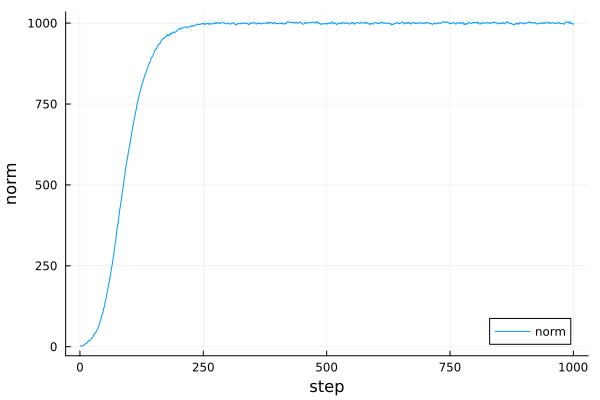

In [23]:
using Plots
plot(df.step, df.norm, label = "norm")
xlabel!("step")
ylabel!("norm")

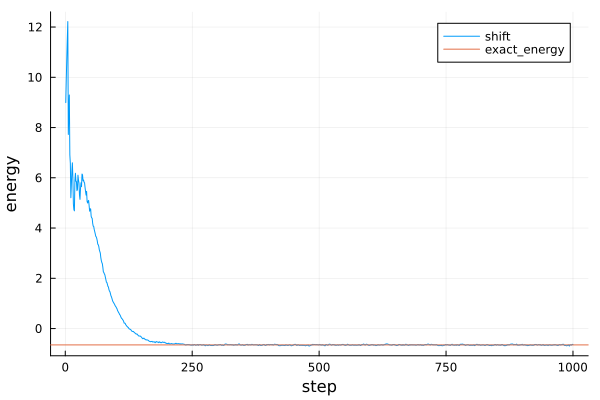

In [24]:
plot(df.step, df.shift, label="shift")
xlabel!("step")
ylabel!("energy")
hline!([ed_result.values[1]], label="exact_energy")

## You said it could deal with large Hilbert space...

In [25]:
add2 = near_uniform(BoseFS{20,20})

BoseFS{20,20}(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

In [26]:
ham2 = HubbardRealSpace(add2, u=6.0, t=[1.0,])

HubbardRealSpace(
  fs"|1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1⟩",
  geometry = CubicGrid((20,), (true,)),
  t = [1.0],
  u = [6.0;;],
)


In [27]:
dimension(ham2) |> float

6.892326441e+10

In [28]:
qmc_problem2 = ProjectorMonteCarloProblem(ham2; last_step = 2000)

ProjectorMonteCarloProblem with 1 replica(s) and 1 spectral state(s):
  Algorithm: FCIQMC(DoubleLogUpdate{Int64}(1000, 0.08, 0.0016), ConstantTimeStep())
  Hamiltonian: HubbardRealSpace(
  fs"|1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1⟩",
  geometry = CubicGrid((20,), (true,)),
  t = [1.0],
  u = [6.0;;],
)

  Style: IsDynamicSemistochastic{Float64,ThresholdCompression,DynamicSemistochastic}()
  Initiator: NonInitiator()
  Threading: false
  Simulation Plan: SimulationPlan(starting_step=0, last_step=2000, walltime=Inf)
  Replica Strategy: NoStats{1}()
  Reporting Strategy: ReportDFAndInfo
  reporting_interval: Int64 1
  info_interval: Int64 100
  io: IJulia.IJuliaStdio{Base.PipeEndpoint}
  writeinfo: Bool false
  Post Step Strategy: ()
  Spectral Strategy: GramSchmidt{1}()
  Maxlength: 2100
  Metadata: OrderedCollections.LittleDict("display_name" => "PMCSimulation")
  Random Seed: 13448537281660734941

In [29]:
qmc_result2 = solve(qmc_problem2)

┌ LogLevel(-1): 
│   progress = nothing
└ @ Rimu ~/.julia/packages/ProgressLogging/6KXlp/src/ProgressLogging.jl:385
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


PMCSimulation with 1 replica(s) and 1 spectral state(s).
  Algorithm:   FCIQMC(DoubleLogUpdate{Int64}(1000, 0.08, 0.0016), ConstantTimeStep())
  Hamiltonian: HubbardRealSpace(
  fs"|1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1⟩",
  geometry = CubicGrid((20,), (true,)),
  t = [1.0],
  u = [6.0;;],
)

  Step:        2000 / 2000
  modified = true, aborted = false, success = true

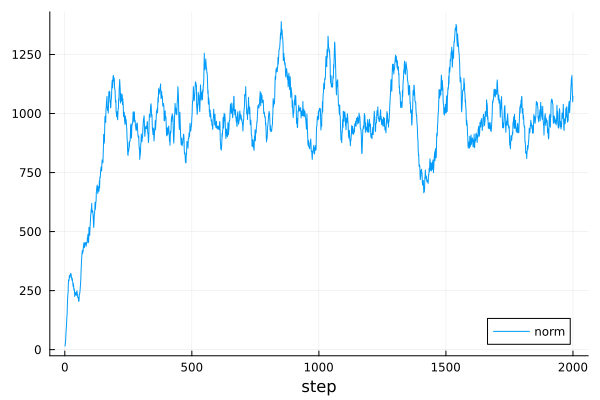

In [30]:
df2 = DataFrame(qmc_result2)
plot(df2.step, df2.norm, label = "norm")
xlabel!("step")

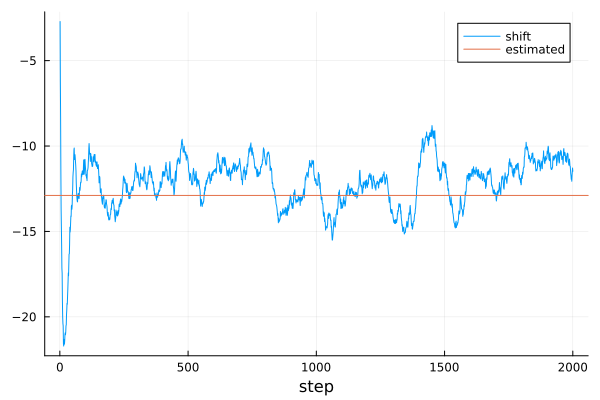

In [31]:
plot(df2.step, df2.shift, label="shift")
xlabel!("step")
E_estimated = -12.894
hline!([E_estimated,], label="estimated")

## Statistical Data analysis

In [32]:
se = shift_estimator(df2; skip=500)

BlockingResult{Float64}
  mean = -12.07 ± 0.25
  with uncertainty of ± 0.03731660957207339
  from 23 blocks after 6 transformations (k = 7).


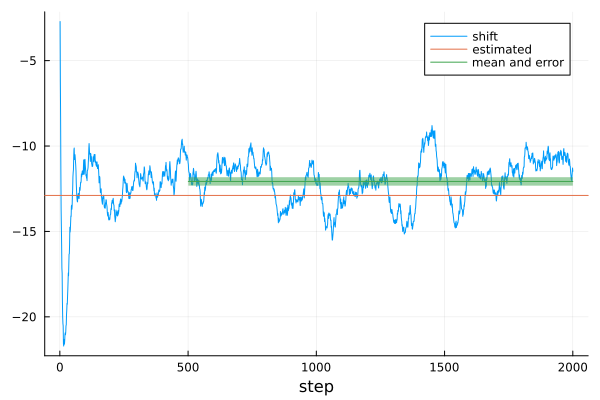

In [33]:
plot!(x->se.mean, df2.step[501:end], ribbon=se.err, label="mean and error")

The discrepancy between the mean of the shift and the exact value is the **population control bias**.

## Importance Sampling

We can turn on importance sampling by wrapping the previously defined Hamiltonian.

In [34]:
is_ham2 = GutzwillerSampling(ham2; g=0.2)

GutzwillerSampling(HubbardRealSpace(
  fs"|1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1⟩",
  geometry = CubicGrid((20,), (true,)),
  t = [1.0],
  u = [6.0;;],
)
; g=0.2)

In [35]:
df3 = DataFrame(solve(ProjectorMonteCarloProblem(is_ham2; last_step = 2000)))
se3 = shift_estimator(df3; skip=500)

┌ LogLevel(-1): 
│   progress = nothing
└ @ Rimu ~/.julia/packages/ProgressLogging/6KXlp/src/ProgressLogging.jl:385
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


BlockingResult{Float64}
  mean = -12.825 ± 0.069
  with uncertainty of ± 0.00725567024337772
  from 46 blocks after 5 transformations (k = 6).


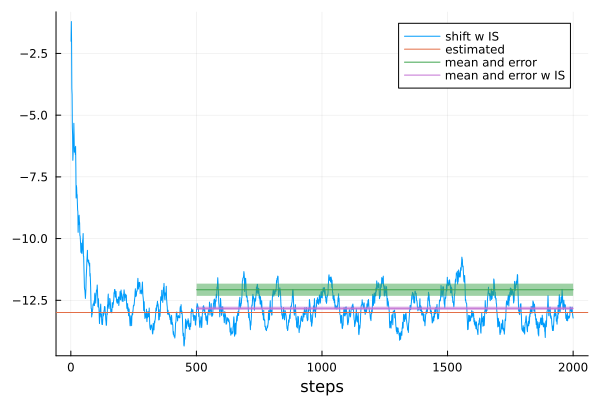

In [36]:
plot(df3.step, df3.shift, label="shift w IS")
xlabel!("steps")
E_estimated = -12.994
hline!([E_estimated,], label="estimated")
plot!(x->se.mean, df3.step[501:end], ribbon=se.err, label="mean and error")
plot!(x->se3.mean, df3.step[501:end], ribbon=se3.err, label="mean and error w IS")